In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import numba
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from catboost import Pool
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score , roc_curve
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import optuna

In [2]:
features = pd.read_parquet('mem_opt_features_less_na.parquet')
ohlc_data = pd.read_parquet('btc-usdt-5m-2018-2025-04-02.parquet')

In [3]:
features[features.select_dtypes(np.float16).columns] = features.select_dtypes(np.float16).astype('Float32')
features.ffill(inplace=True)

In [4]:
# indicator
@numba.njit
def compute_rngfilt(close, atr):
    n = len(close)
    rngfilt = np.zeros_like(close)
    rngfilt[0] = close[0]

    for i in range(1, n):
        prev_rngfilt = rngfilt[i - 1]
        if close[i] > prev_rngfilt:
            rngfilt[i] = max(prev_rngfilt, close[i] - atr[i])
        else:
            rngfilt[i] = min(prev_rngfilt, close[i] + atr[i])

    return rngfilt

@numba.njit
def compute_up_down(rngfilt, length):
    n = len(rngfilt)
    upward = np.zeros(n, dtype=np.int32)
    downward = np.zeros(n, dtype=np.int32)

    for i in range(length + 1, n):
        if rngfilt[i] > rngfilt[i - 1]:
            upward[i] = upward[i - 1] + 1
        elif rngfilt[i] == rngfilt[i - 1]:
            upward[i] = upward[i - 1]

        if rngfilt[i] < rngfilt[i - 1]:
            downward[i] = downward[i - 1] + 1
        elif rngfilt[i] == rngfilt[i - 1]:
            downward[i] = downward[i - 1]

    return upward, downward

def rangefiltv3_n(df, length, mult):
    tempdf = df.copy()

    # Compute ATR (this part isn't JIT-optimized since it's an external function)
    atr = ta.atr(tempdf['high'], tempdf['low'], tempdf['close'], mamode='rma', length=length).round(2)
    atr = np.nan_to_num(atr * mult)  # Replace NaN with 0

    # Convert to NumPy
    close = tempdf['close'].to_numpy()

    # Compute range filter

    rngfilt = compute_rngfilt(close, atr)

    # Compute upward/downward trends
    upward, downward = compute_up_down(rngfilt, length)

    # Compute direction (NumPy vectorized, fast enough)
    direction = np.where(upward == downward, 0, np.where(upward != 0, 1, -1))

    # Assign back to DataFrame
    tempdf['rngfilt'] = rngfilt
    tempdf['upward'] = upward
    tempdf['downward'] = downward
    tempdf['direction'] = direction

    return tempdf[['datetime_ist', 'open', 'high', 'low', 'close', 'rngfilt', 'upward', 'downward', 'direction']]

In [5]:
# strategy 
@numba.njit
def process_trades_tpsl(direct, close_p, datetime_ist, atr_values, take_profit, stop_loss, trailing_sl_multiplier, static_atr, satr_mult):
    entry_time = []
    exit_time = []
    side = []
    entry_price = []
    exit_price = []
    ul_max = []
    ul_min = []
    close_reason = []
    
    curr_pos = None
    prev_pos = None
    um = 0
    umin = 0
    sl_price = None
    tsl_price = None
    tp_price = None
    satr = None
    waiting_for_direction_change = False

    # Find first non-zero direction
    for j in range(len(direct)):
        if direct[j] != 0:
            nonz = j
            break

    for i in range(nonz, len(direct)):
        dir = direct[i]
        current_close = close_p[i]

        if waiting_for_direction_change and dir == prev_pos:
            continue

        # Initialize first trade
        if curr_pos is None and not waiting_for_direction_change:
            curr_pos = dir
            prev_pos = dir
            entry_time.append(datetime_ist[i])
            entry_price.append(current_close)

            # Set TP, SL, TSL
            if take_profit is not None:
                tp_price = current_close * (1 + take_profit / 100) if dir == 1 else current_close * (1 - take_profit / 100)
            if stop_loss is not None:
                sl_price = current_close * (1 - stop_loss / 100) if dir == 1 else current_close * (1 + stop_loss / 100)
            if trailing_sl_multiplier is not None:
                tsl_price = current_close - trailing_sl_multiplier * atr_values[i] if dir == 1 else current_close + trailing_sl_multiplier * atr_values[i]
            if static_atr is not None:
                satr = current_close - satr_mult * atr_values[i] if dir == 1 else current_close + satr_mult * atr_values[i]

        # Update Unrealized Max/Min
        if curr_pos is not None:
            last_entry_price = entry_price[-1]
            if curr_pos == 1:
                um = max(um, current_close - last_entry_price)
                umin = max(umin, last_entry_price - current_close)
            elif curr_pos == -1:
                um = max(um, last_entry_price - current_close)
                umin = max(umin, current_close - last_entry_price)

        # Trailing SL Update
        if curr_pos is not None and tsl_price is not None:
            if curr_pos == 1 and trailing_sl_multiplier is not None and current_close - trailing_sl_multiplier * atr_values[i] > tsl_price:
                tsl_price = current_close - trailing_sl_multiplier * atr_values[i]
            elif curr_pos == -1 and trailing_sl_multiplier is not None and current_close + trailing_sl_multiplier * atr_values[i] < tsl_price:
                tsl_price = current_close + trailing_sl_multiplier * atr_values[i]

        # Exit Conditions (SL, TP, TSL, SATR)
        exit_reason = None
        if curr_pos is not None:
            if take_profit is not None and ((curr_pos == 1 and current_close >= tp_price) or (curr_pos == -1 and current_close <= tp_price)):
                exit_reason = "TP Hit"
            if stop_loss is not None and ((curr_pos == 1 and current_close <= sl_price) or (curr_pos == -1 and current_close >= sl_price)):
                exit_reason = "SL Hit"
            if trailing_sl_multiplier is not None and ((curr_pos == 1 and current_close <= tsl_price) or (curr_pos == -1 and current_close >= tsl_price)):
                exit_reason = "TSL Hit"
            if static_atr is not None and ((curr_pos == 1 and current_close <= satr) or (curr_pos == -1 and current_close >= satr)):
                exit_reason = "SATR Hit"

        if exit_reason is not None and curr_pos is not None:
            side.append(curr_pos)
            ul_max.append(um)
            ul_min.append(umin)
            exit_time.append(datetime_ist[i])
            exit_price.append(current_close)
            close_reason.append(exit_reason)

            prev_pos = curr_pos
            curr_pos = None
            um = 0
            umin = 0
            sl_price = None
            tsl_price = None
            tp_price = None
            waiting_for_direction_change = True

        if curr_pos is not None and curr_pos != dir:
            side.append(curr_pos)
            ul_max.append(um)
            ul_min.append(umin)
            exit_time.append(datetime_ist[i])
            exit_price.append(current_close)
            close_reason.append('Dir_change')

            prev_pos = curr_pos
            curr_pos = None
            um = 0
            umin = 0

            curr_pos = dir
            entry_time.append(datetime_ist[i])
            entry_price.append(current_close)
            waiting_for_direction_change = False

            if take_profit is not None:
                tp_price = current_close * (1 + take_profit / 100) if dir == 1 else current_close * (1 - take_profit / 100)
            if stop_loss is not None:
                sl_price = current_close * (1 - stop_loss / 100) if dir == 1 else current_close * (1 + stop_loss / 100)
            if trailing_sl_multiplier is not None:
                tsl_price = current_close - trailing_sl_multiplier * atr_values[i] if dir == 1 else current_close + trailing_sl_multiplier * atr_values[i]
            if static_atr is not None:
                satr = current_close - satr_mult * atr_values[i] if dir == 1 else current_close + satr_mult * atr_values[i]

        elif waiting_for_direction_change and dir != prev_pos and dir != 0:
            curr_pos = dir
            entry_time.append(datetime_ist[i])
            entry_price.append(current_close)
            waiting_for_direction_change = False  # Reset waiting flag
            um = 0
            umin = 0
            
            # Set new TP, SL, TSL
            if take_profit is not None:
                tp_price = current_close * (1 + take_profit / 100) if dir == 1 else current_close * (1 - take_profit / 100)
            if stop_loss is not None:
                sl_price = current_close * (1 - stop_loss / 100) if dir == 1 else current_close * (1 + stop_loss / 100)
            if trailing_sl_multiplier is not None:
                tsl_price = current_close - trailing_sl_multiplier * atr_values[i] if dir == 1 else current_close + trailing_sl_multiplier * atr_values[i]
            if static_atr is not None:
                satr = current_close - satr_mult * atr_values[i] if dir == 1 else current_close + satr_mult * atr_values[i]
        # Handle the last trade if there is one still open
    if curr_pos is not None:
        exit_time.append(datetime_ist[-1])
        exit_price.append(close_p[-1])
        side.append(curr_pos)
        ul_max.append(um)
        ul_min.append(umin)

    return entry_time, exit_time, side, entry_price, exit_price, ul_max, ul_min

def optimized_tp_sl(df, take_profit:int | float =None, stop_loss: int | float=None, trailing_sl_multiplier : int | float=None, atr_period=14, static_atr : bool = None, satr_mult=1):
    atr_values = ta.atr(df['high'], df['low'], df['close'], mamode='rma', length=atr_period).round(2)
    atr_values = np.nan_to_num(atr_values)
    
    # Convert to NumPy
    direct = df['direction'].to_numpy()
    close_p = df['close'].to_numpy()
    datetime_ist = df['datetime_ist'].to_numpy()
    # Call JIT-optimized function
    entry_time, exit_time, side, entry_price, exit_price, ul_max, ul_min = process_trades_tpsl(
        direct, close_p, datetime_ist, atr_values, take_profit, stop_loss, trailing_sl_multiplier, static_atr, satr_mult
    )
    # Convert results back to Pandas DataFrame
    finaldf = pd.DataFrame({
        'entry_time': entry_time,
        'exit_time': exit_time,
        'side': side,
        'entry_price': entry_price,
        'exit_price': exit_price,
        'ul_max': ul_max,
        'ul_min': ul_min
    })

    finaldf['realized'] = np.where(finaldf['side'] == 1,
                                   finaldf['exit_price'] - finaldf['entry_price'],
                                   finaldf['entry_price'] - finaldf['exit_price'])
    finaldf['cumm_real'] = finaldf['realized'].cumsum()

    return finaldf

In [6]:
# compute trade metrics 2
def compute_trade_metrics(trades: pd.DataFrame, starting_equity: float = 1000, risk_per_trade: float = 1, fixed_risk: bool = False):
    """
    Computes performance metrics from a trade log.

    :param trades: DataFrame with 'entry_price', 'exit_price', 'side', 'realized' columns
    :param starting_equity: Initial capital
    :param risk_per_trade: Fixed amount (if fixed_risk=True) or percentage of equity per trade (if fixed_risk=False)
    :param fixed_risk: If True, use fixed capital per trade; if False, use a percentage of current equity.
    :return: Dictionary with performance metrics
    """
    
    equity = starting_equity
    equity_curve = [equity]
    max_equity = equity
    drawdowns = []
    returns = []
    wins = 0
    losses = 0
    win_amounts = []
    loss_amounts = []
    drawdown_pct = []
    
    for i, trade in trades.iterrows():
        if fixed_risk:
            trade_size = risk_per_trade
        else:
            trade_size = equity * (risk_per_trade / 100)
        
        pnl = trade['realized'] * (trade_size / trade['entry_price'])  # PnL based on trade size
        equity += pnl
        equity_curve.append(equity)
        returns.append((pnl / trade_size))
        
        max_equity = max(max_equity, equity)
        current_drawdown = equity - max_equity
        drawdowns.append(current_drawdown)
        
        if max_equity != 0:  # Avoid division by zero
            drawdown_pct.append((current_drawdown / max_equity) * 100)
        else:
            drawdown_pct.append(0)
        
        if pnl > 0:
            wins += 1
            win_amounts.append(pnl)
        else:
            losses += 1
            loss_amounts.append(pnl)
    
    total_trades = len(trades)
    win_rate = (wins / total_trades) * 100 if total_trades > 0 else 0
    avg_win = np.mean(win_amounts) if wins > 0 else 0
    avg_loss = np.mean(loss_amounts) if losses > 0 else 0
    total_return = equity - starting_equity
    max_drawdown = min(drawdowns) if drawdowns else 0
    max_drawdown_pct = min(drawdown_pct) if drawdown_pct else 0
    average_drawdown = np.mean(drawdown_pct)
    percent_return = (equity / starting_equity - 1) * 100
    #calamr ratio
    start_date = trades['entry_time'].min()
    end_date = trades['exit_time'].max()
    num_years = (end_date - start_date).days / 365.25  # Adjusting for leap years
    compoundr = (1 + np.array(returns)).cumprod()  # Compounding returns
    Cagr = (compoundr[-1]) ** (1 / num_years) - 1 if num_years > 0 else 0
    drawdown = max_drawdown_pct/100
    calmar_ratio = Cagr/abs(drawdown)
    # sharpe ratio
    trades_per_year = len(trades) / num_years if num_years > 0 else 0
    mean_trade_return = np.mean(returns)
    std_trade_return = np.std(returns, ddof=1) 
    sharpe_ratio = mean_trade_return / std_trade_return if std_trade_return > 0 else 0
    sharpe_ratio = sharpe_ratio * np.sqrt(trades_per_year)
    # sortino ratio
    ret_arr = np.array(returns)
    negative_ret = ret_arr[ret_arr<0] 
    std_trade_return_neg = np.std(negative_ret, ddof=1)
    sortino = mean_trade_return / std_trade_return_neg if std_trade_return_neg > 0 else 0
    sortino = sortino * np.sqrt(trades_per_year)
    volatility = std_trade_return * np.sqrt(trades_per_year)
    ulcer_index = np.sqrt((np.array(drawdown_pct)**2).mean())

    
    return {
        "Total Trades": total_trades,
        "Win Rate (%)": win_rate,
        "Average Win": avg_win,
        "Average Loss": avg_loss,
        "Total Return": total_return,
        "Roi %" : percent_return,
        "Cagr" : Cagr*100,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino,
        "Calmar Ratio" : calmar_ratio,
        "Max Drawdown": max_drawdown,
        "Max Drawdown (%)": max_drawdown_pct,
        "Average Drawdown (%)":average_drawdown,
        "Final Equity": equity,
        'volatility' : volatility,
        "Ulcer" : ulcer_index
        # "Equity Curve": equity_curve
    } , equity_curve , drawdown_pct
    # , equity_curve , drawdown_pct
    # Win Rate (%)


#  {'length': 36, 'mult': 3.4220845145425067, 'stop_loss': 0.4630013983446644, 'take_profit': 5.335006473530708}

In [7]:
length , mult , tp , sl = (83.0, 3.17, 0.8400000000000001, 2.44)

In [8]:
signals = rangefiltv3_n(ohlc_data,length,mult)
strategy = optimized_tp_sl(signals,take_profit=tp,stop_loss=sl)
stratgy_perf , equity , drawdown = compute_trade_metrics(strategy,risk_per_trade=100)

In [9]:
strategy

,entry_time,exit_time,side,entry_price,exit_price,ul_max,ul_min,realized,cumm_real
0,2018-03-01 12:55:00,2018-03-01 13:45:00,1,10560.00,10662.00,102.00,45.21,102.00,102.00
1,2018-03-02 10:35:00,2018-03-02 19:50:00,-1,10920.00,10810.13,109.87,215.00,109.87,211.87
2,2018-03-03 02:00:00,2018-03-03 06:35:00,1,11039.01,11150.12,111.11,39.01,111.11,322.98
3,2018-03-04 02:05:00,2018-03-04 08:50:00,-1,11332.10,11235.03,97.07,141.90,97.07,420.05
4,2018-03-04 23:50:00,2018-03-05 00:15:00,1,11267.59,11373.00,105.41,0.00,105.41,525.46
...,...,...,...,...,...,...,...,...,...
5838,2025-03-31 10:50:00,2025-03-31 19:35:00,1,82258.00,83107.98,849.98,864.91,849.98,67338.05
5839,2025-04-01 01:25:00,2025-04-01 10:45:00,-1,82462.27,83300.57,146.45,838.30,-838.30,66499.75
5840,2025-04-01 10:45:00,2025-04-01 14:00:00,1,83300.57,84056.98,756.41,367.45,756.41,67256.16
5841,2025-04-01 18:15:00,2025-04-01 19:40:00,-1,83634.70,82796.10,838.60,204.43,838.60,68094.76


In [10]:
strategy['ret'] = ((strategy['realized']/strategy['entry_price'])*100)

In [11]:
stratgy_perf

{'Total Trades': 5843,
 'Win Rate (%)': 51.65154886188602,
 'Average Win': np.float64(18.837621736886177),
 'Average Loss': np.float64(-19.426619391959786),
 'Total Return': 1971.742619636097,
 'Roi %': 197.1742619636097,
 'Cagr': np.float64(16.615716732942264),
 'Sharpe Ratio': np.float64(0.610303825795771),
 'Sortino Ratio': np.float64(0.9853683669060274),
 'Calmar Ratio': np.float64(0.34952146282502905),
 'Max Drawdown': -1455.2675213173109,
 'Max Drawdown (%)': -47.53847331332587,
 'Average Drawdown (%)': np.float64(-23.253344842676707),
 'Final Equity': 2971.742619636097,
 'volatility': np.float64(0.35615345274099985),
 'Ulcer': np.float64(26.00058336064924)}

In [12]:
# labels from live computed
strategy['label'] = np.where(strategy['realized'] > 0 , 1 , 0)

In [13]:
# this is used when creating feature when there is no temporl order is necessary
merged_df = pd.merge(
    strategy,              # left DataFrame
    features,                # right DataFrame
    left_on='entry_time',    # column from trade_logs
    right_on='datetime',     # column from features
    how='left'               # keep all rows from trade_logs
)

In [14]:
no_na = merged_df.dropna(ignore_index=True)

label
1    2996
0    2815
Name: count, dtype: int64

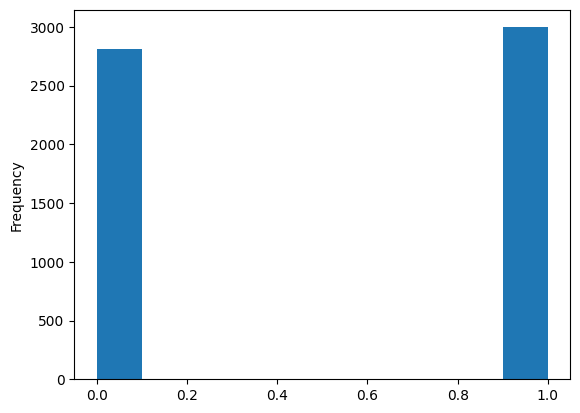

In [15]:
no_na['label'].plot.hist()
no_na['label'].value_counts()

In [16]:
# if dataset is balanced
df_balanced = no_na

In [17]:
train_test_data = df_balanced.drop(columns=['entry_time', 'exit_time','entry_price', 'exit_price',
       'ul_max', 'ul_min', 'realized','ret', 'cumm_real','datetime']).dropna(ignore_index=True)

In [18]:
X = train_test_data.drop(columns=['label'])
y = train_test_data['label']
# Train/test split
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


model_rf = RandomForestClassifier(n_estimators=100,
                                  max_depth=10,
                                  random_state=42)
model_rf.fit(X_train,y_train)


RandomForestClassifier(max_depth=10, random_state=42)

In [19]:
# Predict
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]
threshold = 0.50
y_pred = (y_proba_rf > threshold).astype(int)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

[[367 222]
 [244 330]]
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       589
           1       0.60      0.57      0.59       574

    accuracy                           0.60      1163
   macro avg       0.60      0.60      0.60      1163
weighted avg       0.60      0.60      0.60      1163

ROC AUC: 0.6149204640239465


In [20]:
# Catboost data split
train_pool = Pool(X_train,y_train)
test_pool = Pool(X_test,y_test)

In [21]:
model_catboost = CatBoostClassifier(iterations=1000,
                                    learning_rate=0.05,
                                    depth=6,
                                    loss_function='Logloss',
                                    eval_metric='AUC',
                                    random_seed=42,
                                    early_stopping_rounds=50)

model_catboost.fit(train_pool,eval_set=test_pool)

0:	test: 0.6135392	best: 0.6135392 (0)	total: 283ms	remaining: 4m 42s
1:	test: 0.6200804	best: 0.6200804 (1)	total: 343ms	remaining: 2m 51s
2:	test: 0.6146646	best: 0.6200804 (1)	total: 408ms	remaining: 2m 15s
3:	test: 0.6247419	best: 0.6247419 (3)	total: 471ms	remaining: 1m 57s
4:	test: 0.6277367	best: 0.6277367 (4)	total: 532ms	remaining: 1m 45s
5:	test: 0.6293473	best: 0.6293473 (5)	total: 593ms	remaining: 1m 38s
6:	test: 0.6314355	best: 0.6314355 (6)	total: 654ms	remaining: 1m 32s
7:	test: 0.6324323	best: 0.6324323 (7)	total: 715ms	remaining: 1m 28s
8:	test: 0.6332324	best: 0.6332324 (8)	total: 777ms	remaining: 1m 25s
9:	test: 0.6335429	best: 0.6335429 (9)	total: 839ms	remaining: 1m 23s
10:	test: 0.6356800	best: 0.6356800 (10)	total: 901ms	remaining: 1m 20s
11:	test: 0.6395178	best: 0.6395178 (11)	total: 961ms	remaining: 1m 19s
12:	test: 0.6399052	best: 0.6399052 (12)	total: 1.02s	remaining: 1m 17s
13:	test: 0.6406033	best: 0.6406033 (13)	total: 1.08s	remaining: 1m 16s
14:	test: 0.

In [22]:
# Predict
y_proba_gbdt = model_catboost.predict_proba(test_pool)[:, 1]
threshold_gbdt = 0.50
y_pred_gbdt = (y_proba_gbdt > threshold_gbdt).astype(int)

# Evaluate
print(confusion_matrix(y_test, y_pred_gbdt))
print(classification_report(y_test, y_pred_gbdt))
print("ROC AUC:", roc_auc_score(y_test, y_proba_gbdt))

[[387 202]
 [251 323]]
              precision    recall  f1-score   support

           0       0.61      0.66      0.63       589
           1       0.62      0.56      0.59       574

    accuracy                           0.61      1163
   macro avg       0.61      0.61      0.61      1163
weighted avg       0.61      0.61      0.61      1163

ROC AUC: 0.6406032784557776


In [23]:
gbdt_model_test = df_balanced[split_idx:][['entry_time', 'exit_time', 'side', 'entry_price', 'exit_price','realized','ret']]
gbdt_model_test['predicted'] = y_pred_gbdt

In [24]:
model_test = df_balanced[split_idx:][['entry_time', 'exit_time', 'side', 'entry_price', 'exit_price','realized','ret']]

In [25]:
model_test['predicted'] = y_pred

DEEP LEARNING MODEL

In [26]:
# data prepration for lstm 

preprocessed = pd.DataFrame(StandardScaler().fit_transform(features.drop(columns='datetime')),columns=features.columns.drop(labels=['datetime']))
preprocessed['datetime'] = features['datetime']
preprocessed = preprocessed.dropna()

In [27]:
merged_df_ANN = pd.merge(
    df_balanced[['entry_time','label']],              # left DataFrame
    preprocessed,                # right DataFrame
    left_on='entry_time',    # column from trade_logs
    right_on='datetime',     # column from features
    how='left'               # keep all rows from trade_logs
)

In [28]:
train_test_data_ANN = merged_df_ANN.drop(columns=['entry_time','datetime']).dropna(ignore_index=True)

LONG SHORT TERM MEMORY (LSTM) 

In [29]:
def prepare_lstm_sequences(df_balanced, preprocessed, split_index, window_size):
    # Ensure datetime is in datetime format
    preprocessed = preprocessed.set_index('datetime')
    
    def extract_sequences(df_subset):
        sequences = []
        labels = []
        for _, row in df_subset.iterrows():
            entry_time = row['entry_time']
            label = row['label']

            try:
                # Find the position of entry_time
                entry_idx = preprocessed.index.get_loc(entry_time)
                
                # Extract window_size records BEFORE (and including) entry_time
                start_idx = max(0, entry_idx - window_size + 1)
                window = preprocessed.iloc[start_idx:entry_idx + 1]
                
                if len(window) == window_size:
                    sequences.append(window.values)
                    labels.append(label)
            except KeyError:
                continue  # If entry_time not in index, skip

        return np.array(sequences), np.array(labels)

    # Split df_balanced
    df_train = df_balanced.iloc[:split_index]
    df_test = df_balanced.iloc[split_index:]

    # Extract sequences
    X_train, y_train = extract_sequences(df_train)
    X_test, y_test = extract_sequences(df_test)

    return X_train, y_train, X_test, y_test

In [30]:
window_size = 100

X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = prepare_lstm_sequences(df_balanced, preprocessed, split_idx, window_size)

print("Train shape:", X_train_lstm.shape, y_train_lstm.shape)
print("Test shape:", X_test_lstm.shape, y_test_lstm.shape)

Train shape: (4648, 100, 341) (4648,)
Test shape: (1163, 100, 341) (1163,)


In [31]:
torch.manual_seed(42)

In [32]:
# model traning of lstm

# Convert to float32 for compatibility
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_lstm, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_lstm, dtype=torch.float32)

# Add extra dimension to labels for binary classification
y_train_tensor = y_train_tensor.unsqueeze(1)
y_test_tensor = y_test_tensor.unsqueeze(1)

batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [33]:
# lstm model define 

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return self.sigmoid(out)

In [34]:
input_size_LSTM = X_train_lstm.shape[2]  # 341
# hidden_size = 128

# model_LSTM = LSTMClassifier(input_size=input_size_LSTM, hidden_size=hidden_size)
model_LSTM = LSTMClassifier(input_size=input_size_LSTM,hidden_size=128,num_layers=1)

# Binary classification
criterion_LSTM = nn.BCELoss()
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=0.001)


In [35]:
num_epochs = 21

for epoch in range(num_epochs):
    model_LSTM.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer_LSTM.zero_grad()
        outputs_LSTM = model_LSTM(X_batch)
        loss = criterion_LSTM(outputs_LSTM, y_batch)
        loss.backward()
        optimizer_LSTM.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/21, Loss: 49.3302
Epoch 2/21, Loss: 47.4866
Epoch 3/21, Loss: 46.4418
Epoch 4/21, Loss: 45.2957
Epoch 5/21, Loss: 43.7137
Epoch 6/21, Loss: 42.1365
Epoch 7/21, Loss: 39.6837
Epoch 8/21, Loss: 37.8252
Epoch 9/21, Loss: 34.9580
Epoch 10/21, Loss: 31.0898
Epoch 11/21, Loss: 27.3397
Epoch 12/21, Loss: 24.2503
Epoch 13/21, Loss: 21.5583
Epoch 14/21, Loss: 18.1257
Epoch 15/21, Loss: 14.2644
Epoch 16/21, Loss: 13.4603
Epoch 17/21, Loss: 11.1452
Epoch 18/21, Loss: 9.6228
Epoch 19/21, Loss: 7.2037
Epoch 20/21, Loss: 6.9046
Epoch 21/21, Loss: 6.0315


In [36]:
# Step 4: Evaluation (accuracy)
def evaluate_model_lstm(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    predicted_labels = []
    predicted_proba = []
    with torch.no_grad():
        for batch_X, batch_Y in data_loader:
            outputs = model(batch_X).squeeze()
            predicted = (outputs > 0.50).long()  # threshold at 0.5
            predicted_labels.append(predicted)
            predicted_proba.append(outputs)
            # correct += (predicted == batch_Y).sum().item()
            correct += (predicted == batch_Y.long()).sum().item()
            total += batch_Y.size(0)
        all_preds_tensor = torch.cat(predicted_labels)
        all_preds_proba = torch.cat(predicted_proba)
    return (correct / total) , all_preds_tensor.tolist() , all_preds_proba.tolist()

accuracy_lstm , labels_lstm , pred_proba_lstm = evaluate_model_lstm(model_LSTM, test_loader)
print(f"Test Accuracy: {accuracy_lstm :.2f}%")

Test Accuracy: 33.22%


In [37]:
pl_LSTM = np.array(labels_lstm)

In [38]:
# Evaluate
print(confusion_matrix(y_test_lstm, pl_LSTM))
print(classification_report(y_test_lstm, pl_LSTM))
print("ROC AUC:", roc_auc_score(y_test_lstm, pred_proba_lstm))

[[295 294]
 [206 368]]
              precision    recall  f1-score   support

           0       0.59      0.50      0.54       589
           1       0.56      0.64      0.60       574

    accuracy                           0.57      1163
   macro avg       0.57      0.57      0.57      1163
weighted avg       0.57      0.57      0.57      1163

ROC AUC: 0.5873683027395397


In [39]:
LSTM_test_data =  df_balanced[split_idx:][['entry_time', 'exit_time', 'side', 'entry_price', 'exit_price','realized','ret']]
LSTM_test_data['predicted'] = pl_LSTM

ARTIFICIAL NEURAL NETWORK / MULTI LAYER PERCEPTRON

In [40]:
torch.manual_seed(42)

In [41]:
# train test split
X_ANN = train_test_data_ANN.drop(columns='label').values
Y_ANN = train_test_data_ANN['label'].values

X_train_ANN , Y_train_ANN = torch.tensor(X_ANN[:split_idx],dtype=torch.float32) , torch.tensor(Y_ANN[:split_idx],dtype=torch.long)
X_test_ANN , Y_test_ANN = torch.tensor(X_ANN[split_idx:],dtype=torch.float32) , torch.tensor(Y_ANN[split_idx:],dtype=torch.long)

train_dataset_ANN = TensorDataset(X_train_ANN,Y_train_ANN)
test_datset_ANN = TensorDataset(X_test_ANN,Y_test_ANN)

batch_size_ANN = 35

train_ANN_loader = DataLoader(train_dataset_ANN,batch_size=batch_size_ANN,shuffle=True)
test_ANN_loader = DataLoader(test_datset_ANN,batch_size=batch_size_ANN)

In [42]:
class BinaryANN(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.network = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
    def forward(self,x):
        return self.network(x)


In [43]:
# Step 2: Set up model, loss_ANN, and optimizer_ANN
input_size = X_train_ANN.shape[1]  # number of features
model_ANN = BinaryANN(input_size)

criterion_ANN = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer_ANN = optim.Adam(model_ANN.parameters(), lr=0.001)

# Step 3: Training loop
epochs = 300

for epoch in range(epochs):
    model_ANN.train()
    total_loss_ANN = 0
    for batch_X_ANN, batch_Y_ANN in train_ANN_loader:
        outputs_ANN = model_ANN(batch_X_ANN).squeeze()  # shape: (batch_size,)
        loss_ANN = criterion_ANN(outputs_ANN, batch_Y_ANN.float())  # convert Y to float for BCE
        optimizer_ANN.zero_grad()
        loss_ANN.backward()
        optimizer_ANN.step()
        total_loss_ANN += loss_ANN.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss_ANN:.4f}")


Epoch 1/300, Loss: 91.4429
Epoch 2/300, Loss: 90.0244
Epoch 3/300, Loss: 88.8042
Epoch 4/300, Loss: 89.1493
Epoch 5/300, Loss: 88.1691
Epoch 6/300, Loss: 88.1958
Epoch 7/300, Loss: 87.7280
Epoch 8/300, Loss: 87.7806
Epoch 9/300, Loss: 87.3595
Epoch 10/300, Loss: 86.8708
Epoch 11/300, Loss: 86.9104
Epoch 12/300, Loss: 86.4870
Epoch 13/300, Loss: 86.1201
Epoch 14/300, Loss: 86.0564
Epoch 15/300, Loss: 85.4963
Epoch 16/300, Loss: 86.4540
Epoch 17/300, Loss: 85.8856
Epoch 18/300, Loss: 85.4240
Epoch 19/300, Loss: 85.4847
Epoch 20/300, Loss: 85.0761
Epoch 21/300, Loss: 85.4503
Epoch 22/300, Loss: 85.3281
Epoch 23/300, Loss: 85.3720
Epoch 24/300, Loss: 83.7806
Epoch 25/300, Loss: 84.3100
Epoch 26/300, Loss: 83.8242
Epoch 27/300, Loss: 83.6113
Epoch 28/300, Loss: 83.7709
Epoch 29/300, Loss: 83.4561
Epoch 30/300, Loss: 82.9272
Epoch 31/300, Loss: 82.7911
Epoch 32/300, Loss: 82.6966
Epoch 33/300, Loss: 81.6218
Epoch 34/300, Loss: 82.5991
Epoch 35/300, Loss: 82.1379
Epoch 36/300, Loss: 81.7935
E

In [44]:
# Step 4: Evaluation (accuracy)
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    predicted_labels = []
    predicted_proba = []
    with torch.no_grad():
        for batch_X, batch_Y in data_loader:
            outputs = model(batch_X).squeeze()
            predicted = (outputs > 0.50).long()  # threshold at 0.5
            predicted_labels.append(predicted)
            predicted_proba.append(outputs)
            correct += (predicted == batch_Y).sum().item()
            total += batch_Y.size(0)
        all_preds_tensor = torch.cat(predicted_labels)
        all_preds_proba = torch.cat(predicted_proba)
    return (correct / total) , all_preds_tensor.tolist() , all_preds_proba.tolist()

accuracy , labels_ANN , pred_proba_ANN = evaluate_model(model_ANN, test_ANN_loader)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 55.37%


In [45]:
pl = np.array(labels_ANN)

In [46]:
# Evaluate
print(confusion_matrix(Y_test_ANN, pl))
print(classification_report(Y_test_ANN, pl))
print("ROC AUC:", roc_auc_score(Y_test_ANN, pred_proba_ANN))

[[328 261]
 [258 316]]
              precision    recall  f1-score   support

           0       0.56      0.56      0.56       589
           1       0.55      0.55      0.55       574

    accuracy                           0.55      1163
   macro avg       0.55      0.55      0.55      1163
weighted avg       0.55      0.55      0.55      1163

ROC AUC: 0.5706477050217992


In [47]:
ANN_test_data = df_balanced[split_idx:][['entry_time', 'exit_time', 'side', 'entry_price', 'exit_price','realized','ret']]
ANN_test_data['predicted'] = pl

PORTFOLIO PERFORMANCE EVALUATION

In [48]:
# compute trade metrics metalabel
def compute_trade_metrics_metalabel(trades: pd.DataFrame, starting_equity: float = 1000, risk_per_trade: float = 1, fixed_risk: bool = False):
    """
    Computes performance metrics from a trade log.

    :param trades: DataFrame with 'entry_price', 'exit_price', 'side', 'realized' columns
    :param starting_equity: Initial capital
    :param risk_per_trade: Fixed amount (if fixed_risk=True) or percentage of equity per trade (if fixed_risk=False)
    :param fixed_risk: If True, use fixed capital per trade; if False, use a percentage of current equity.
    :return: Dictionary with performance metrics
    """
    
    equity = starting_equity
    equity_curve = [equity]
    max_equity = equity
    drawdowns = []
    returns = []
    wins = 0
    losses = 0
    win_amounts = []
    loss_amounts = []
    drawdown_pct = []
    
    for i, trade in trades.iterrows():
        if fixed_risk:
            trade_size = risk_per_trade
        else:
            trade_size = equity * (risk_per_trade / 100)
        if trade['predicted'] == 1:
            pnl = trade['realized'] * (trade_size / trade['entry_price'])  # PnL based on trade size
            equity += pnl
            equity_curve.append(equity)
            returns.append((pnl / trade_size))
            
            max_equity = max(max_equity, equity)
            current_drawdown = equity - max_equity
            drawdowns.append(current_drawdown)
            
            if max_equity != 0:  # Avoid division by zero
                drawdown_pct.append((current_drawdown / max_equity) * 100)
            else:
                drawdown_pct.append(0)
            
            if pnl > 0:
                wins += 1
                win_amounts.append(pnl)
            else:
                losses += 1
                loss_amounts.append(pnl)
    
    total_trades = trades['predicted'].sum()
    win_rate = (wins / total_trades) * 100 if total_trades > 0 else 0
    avg_win = np.mean(win_amounts) if wins > 0 else 0
    avg_loss = np.mean(loss_amounts) if losses > 0 else 0
    total_return = equity - starting_equity
    max_drawdown = min(drawdowns) if drawdowns else 0
    max_drawdown_pct = min(drawdown_pct) if drawdown_pct else 0
    average_drawdown = np.mean(drawdown_pct)
    percent_return = (equity / starting_equity - 1) * 100
    #calamr ratio
    start_date = trades['entry_time'].min()
    end_date = trades['exit_time'].max()
    num_years = (end_date - start_date).days / 365.25  # Adjusting for leap years
    compoundr = (1 + np.array(returns)).cumprod()  # Compounding returns
    Cagr = (compoundr[-1]) ** (1 / num_years) - 1 if num_years > 0 else 0
    drawdown = max_drawdown_pct/100
    calmar_ratio = Cagr/abs(drawdown)
    # sharpe ratio
    trades_per_year = len(trades) / num_years if num_years > 0 else 0
    mean_trade_return = np.mean(returns)
    std_trade_return = np.std(returns, ddof=1) 
    sharpe_ratio = mean_trade_return / std_trade_return if std_trade_return > 0 else 0
    sharpe_ratio = sharpe_ratio * np.sqrt(trades_per_year)
    # sortino ratio
    ret_arr = np.array(returns)
    negative_ret = ret_arr[ret_arr<0] 
    std_trade_return_neg = np.std(negative_ret, ddof=1)
    sortino = mean_trade_return / std_trade_return_neg if std_trade_return_neg > 0 else 0
    sortino = sortino * np.sqrt(trades_per_year)
    volatility = std_trade_return * np.sqrt(trades_per_year)
    ulcer_index = np.sqrt((np.array(drawdown_pct)**2).mean())

    
    return {
        "Total Trades": total_trades,
        "Win Rate (%)": win_rate,
        "Average Win": avg_win,
        "Average Loss": avg_loss,
        "Total Return": total_return,
        "Roi %" : percent_return,
        "Cagr" : Cagr*100,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino,
        "Calmar Ratio" : calmar_ratio,
        "Max Drawdown": max_drawdown,
        "Max Drawdown (%)": max_drawdown_pct,
        "Average Drawdown (%)":average_drawdown,
        "Final Equity": equity,
        'volatility' : volatility,
        "Ulcer" : ulcer_index
        # "Equity Curve": equity_curve
    } , equity_curve , drawdown_pct
    # , equity_curve , drawdown_pct
    # Win Rate (%)


#  {'length': 36, 'mult': 3.4220845145425067, 'stop_loss': 0.4630013983446644, 'take_profit': 5.335006473530708}

In [49]:
perf_no_meta , equity_non_meta , dd_non_meta = compute_trade_metrics(model_test,risk_per_trade=100)
perf_no_meta

{'Total Trades': 1163,
 'Win Rate (%)': 49.35511607910576,
 'Average Win': np.float64(9.983451507253422),
 'Average Loss': np.float64(-8.962410498931659),
 'Total Return': 451.64138129271555,
 'Roi %': 45.16413812927156,
 'Cagr': np.float64(38.387148644373845),
 'Sharpe Ratio': np.float64(1.1609683201999095),
 'Sortino Ratio': np.float64(2.070475210292878),
 'Calmar Ratio': np.float64(1.054365747403306),
 'Max Drawdown': -449.13558754062,
 'Max Drawdown (%)': -36.407810798969706,
 'Average Drawdown (%)': np.float64(-17.14612487779333),
 'Final Equity': 1451.6413812927156,
 'volatility': np.float64(0.32563178189528336),
 'Ulcer': np.float64(20.488709908041834)}

In [50]:
perf_meta_rf , equity_meta_rf , dd_meta_rf = compute_trade_metrics_metalabel(model_test,risk_per_trade=100)
perf_meta_rf

{'Total Trades': np.int64(552),
 'Win Rate (%)': np.float64(59.78260869565217),
 'Average Win': np.float64(12.711675151216555),
 'Average Loss': np.float64(-15.210961711904352),
 'Total Return': 818.0192998586958,
 'Roi %': 81.80192998586959,
 'Cagr': np.float64(68.38243042172299),
 'Sharpe Ratio': np.float64(3.106072645128706),
 'Sortino Ratio': np.float64(5.946687436041495),
 'Calmar Ratio': np.float64(2.4035998641789535),
 'Max Drawdown': -352.0006824209265,
 'Max Drawdown (%)': -28.45000594351496,
 'Average Drawdown (%)': np.float64(-7.773940077813812),
 'Final Equity': 1818.0192998586958,
 'volatility': np.float64(0.37651612351528807),
 'Ulcer': np.float64(11.489128643456297)}

In [51]:
perf_meta_gbdt , equity_meta_gbdt , dd_meta_gbdt = compute_trade_metrics_metalabel(gbdt_model_test,risk_per_trade=100)
perf_meta_gbdt

{'Total Trades': np.int64(525),
 'Win Rate (%)': np.float64(61.523809523809526),
 'Average Win': np.float64(11.390359141037793),
 'Average Loss': np.float64(-14.749600049046439),
 'Total Return': 699.6667926478281,
 'Roi %': 69.96667926478281,
 'Cagr': np.float64(58.78605125689984),
 'Sharpe Ratio': np.float64(2.8144026318879356),
 'Sortino Ratio': np.float64(5.771491255179028),
 'Calmar Ratio': np.float64(1.9382390076024483),
 'Max Drawdown': -357.0409937734589,
 'Max Drawdown (%)': -30.32961932265344,
 'Average Drawdown (%)': np.float64(-10.778233201361385),
 'Final Equity': 1699.666792647828,
 'volatility': np.float64(0.39143276514472825),
 'Ulcer': np.float64(14.62687069581035)}

In [52]:
perf_meta_ANN , equity_meta_ANN , dd_meta_ANN = compute_trade_metrics_metalabel(ANN_test_data,risk_per_trade=100)
perf_meta_ANN

{'Total Trades': np.int64(577),
 'Win Rate (%)': np.float64(54.76603119584056),
 'Average Win': np.float64(11.136156975399977),
 'Average Loss': np.float64(-11.9479012652224),
 'Total Return': 400.6233740033458,
 'Roi %': 40.06233740033458,
 'Cagr': np.float64(34.137752975750836),
 'Sharpe Ratio': np.float64(1.827436426243774),
 'Sortino Ratio': np.float64(3.191963162652681),
 'Calmar Ratio': np.float64(1.3219431646505495),
 'Max Drawdown': -308.39722603596215,
 'Max Drawdown (%)': -25.82391882541714,
 'Average Drawdown (%)': np.float64(-8.715560295967153),
 'Final Equity': 1400.6233740033458,
 'volatility': np.float64(0.35945838772906713),
 'Ulcer': np.float64(11.846796936529316)}

In [53]:
perf_meta_LSTM , equity_meta_LSTM , dd_meta_LSTM = compute_trade_metrics_metalabel(LSTM_test_data,risk_per_trade=100)
perf_meta_LSTM

{'Total Trades': np.int64(662),
 'Win Rate (%)': np.float64(55.58912386706949),
 'Average Win': np.float64(11.013333874033629),
 'Average Loss': np.float64(-11.557517558683678),
 'Total Return': 654.9967033913745,
 'Roi %': 65.49967033913744,
 'Cagr': np.float64(55.14203426056243),
 'Sharpe Ratio': np.float64(2.3711527796084315),
 'Sortino Ratio': np.float64(4.516320009540196),
 'Calmar Ratio': np.float64(1.828241432178135),
 'Max Drawdown': -359.66706645726606,
 'Max Drawdown (%)': -30.16124308859316,
 'Average Drawdown (%)': np.float64(-10.840334495934071),
 'Final Equity': 1654.9967033913745,
 'volatility': np.float64(0.3516249237125606),
 'Ulcer': np.float64(14.28158416737587)}

In [54]:
all_performance = pd.DataFrame([perf_no_meta,perf_meta_rf,perf_meta_gbdt,perf_meta_ANN,perf_meta_LSTM],index=['non_meta','Random Forest','CatBoost','MLP','LSTM'])

In [55]:
all_performance

,Total Trades,Win Rate (%),Average Win,Average Loss,Total Return,Roi %,Cagr,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max Drawdown,Max Drawdown (%),Average Drawdown (%),Final Equity,volatility,Ulcer
non_meta,1163,49.355116,9.983452,-8.962410,451.641381,45.164138,38.387149,1.160968,2.070475,1.054366,-449.135588,-36.407811,-17.146125,1451.641381,0.325632,20.488710
Random Forest,552,59.782609,12.711675,-15.210962,818.019300,81.801930,68.382430,3.106073,5.946687,2.403600,-352.000682,-28.450006,-7.773940,1818.019300,0.376516,11.489129
CatBoost,525,61.523810,11.390359,-14.749600,699.666793,69.966679,58.786051,2.814403,5.771491,1.938239,-357.040994,-30.329619,-10.778233,1699.666793,0.391433,14.626871
MLP,577,54.766031,11.136157,-11.947901,400.623374,40.062337,34.137753,1.827436,3.191963,1.321943,-308.397226,-25.823919,-8.715560,1400.623374,0.359458,11.846797
LSTM,662,55.589124,11.013334,-11.557518,654.996703,65.499670,55.142034,2.371153,4.516320,1.828241,-359.667066,-30.161243,-10.840334,1654.996703,0.351625,14.281584


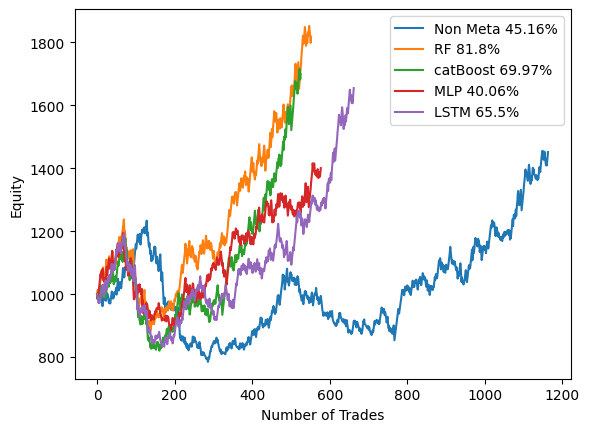

In [56]:
# Assuming equity_non_meta, equity_meta_rf, etc., are already defined
pd.Series(equity_non_meta).plot.line(label=f'Non Meta {np.round(perf_no_meta['Roi %'],2)}%')
pd.Series(equity_meta_rf).plot.line(label=f'RF {np.round(perf_meta_rf['Roi %'],2)}%')
pd.Series(equity_meta_gbdt).plot.line(label=f'catBoost {np.round(perf_meta_gbdt['Roi %'],2)}%')
pd.Series(equity_meta_ANN).plot.line(label=f'MLP {np.round(perf_meta_ANN['Roi %'],2)}%')
pd.Series(equity_meta_LSTM).plot.line(label=f'LSTM {np.round(perf_meta_LSTM['Roi %'],2)}%')

# axis labels
plt.xlabel('Number of Trades')
plt.ylabel('Equity')
# Show legend
plt.legend()

# Save figure with 300 DPI
# plt.savefig('equity_plot.png', dpi=600,format='png', bbox_inches='tight')

# Display plot
plt.show()

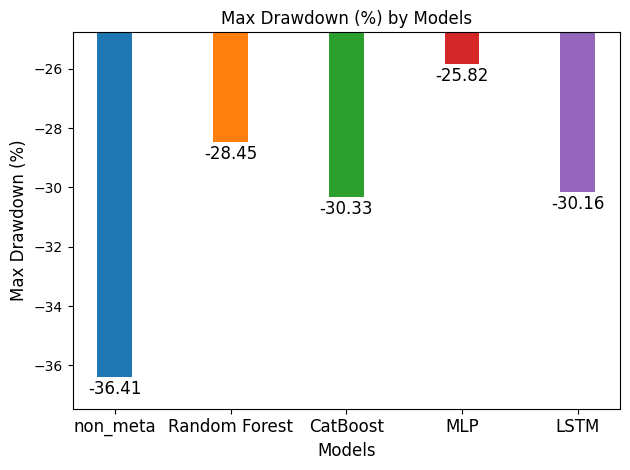

In [57]:
# Create the bar plot with smaller figure size
# plt.figure(figsize=(8, 4))

color_map = {
    'non_meta': 'tab:blue',
    'Random Forest': 'tab:orange',
    'CatBoost': 'tab:green',
    'MLP': 'tab:red',
    'LSTM': 'tab:purple'
}

# Create a list of colors in the correct order for plotting,
# by looking up each model's color from the 'color_map'
colors = [color_map[model] for model in all_performance.index]

bars = plt.bar(
    range(len(all_performance)),
    all_performance['Max Drawdown (%)'],
    width=0.3,
    color=colors,            # Fill color of bars        
    linewidth=1.5
)

# Customize the plot
plt.title('Max Drawdown (%) by Models', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Max Drawdown (%)', fontsize=12)

# Set y-axis limits to handle both positive and negative values
min_val = min(all_performance['Max Drawdown (%)'])
max_val = max(all_performance['Max Drawdown (%)'])
y_range = max_val - min_val
margin = y_range * 0.1  # 10% margin

plt.ylim(min_val - margin, max_val + margin)

# X-axis labels
plt.xticks(range(len(all_performance)), all_performance.index,fontsize=12)

# Add value labels on top of bars (or below for negative values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    
    # Position label above bar for positive values, below for negative values
    if height >= 0:
        label_y = height + (max_val - min_val) * 0.01  # Small offset above
        va = 'bottom'
    else:
        label_y = height - (max_val - min_val) * 0.01  # Small offset below
        va = 'top'
    
    plt.text(bar.get_x() + bar.get_width()/2., label_y,
             f'{height:.2f}', ha='center', va=va, fontsize=12)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

# Save as SVG with 300 DPI
# plt.savefig('Max Drawdown_png (%).png', format='png', dpi=600, bbox_inches='tight')

# Layout and grid
plt.tight_layout()
plt.grid(axis='y', alpha=0.0, linestyle='--')  # Made grid slightly visible

# Show plot
plt.show()

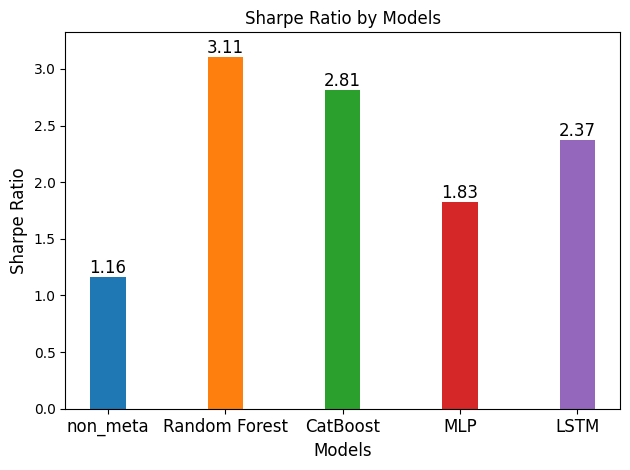

In [58]:
# Create the bar plot with smaller figure size
# plt.figure(figsize=(8, 4))

color_map = {
    'non_meta': 'tab:blue',
    'Random Forest': 'tab:orange',
    'CatBoost': 'tab:green',
    'MLP': 'tab:red',
    'LSTM': 'tab:purple'
}

# Create a list of colors in the correct order for plotting,
# by looking up each model's color from the 'color_map'
colors = [color_map[model] for model in all_performance.index]

bars = plt.bar(
    range(len(all_performance)),
    all_performance['Sharpe Ratio'],
    width=0.3,
    color= colors,            # Fill color of bars        # Border color of bars
    linewidth=1.5
                          # Thicker border for emphasis
)

# *+-./OX\ox|
# Customize the plot
plt.title('Sharpe Ratio by Models', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)

# Set y-axis limits to reduce bar height visually
plt.ylim(0, max(all_performance['Sharpe Ratio']) * 1.07)

# X-axis labels
plt.xticks(range(len(all_performance)), all_performance.index,fontsize=12) #rotation=45, ha='right')

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 0.0000001,
             f'{height:.2f}', ha='center', va='bottom', fontsize=12)

# Save as SVG with 300 DPI
# plt.savefig('Sharpe Ratio.png', format='png', dpi=600, bbox_inches='tight')

# Layout and grid
plt.tight_layout()
plt.grid(axis='y', alpha=0.0, linestyle='--')

# Show plot
plt.show()


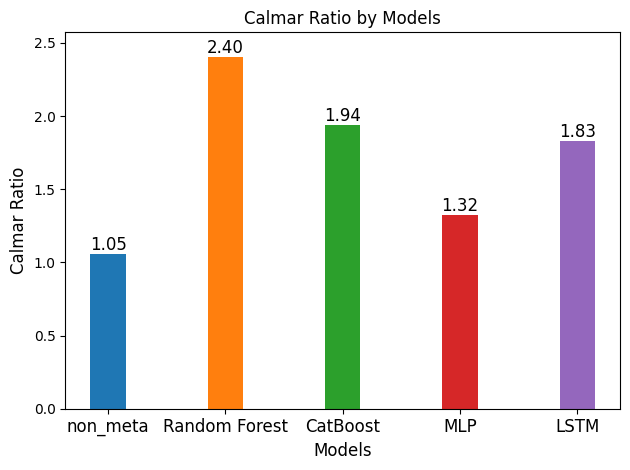

In [59]:
# Create the bar plot with smaller figure size
# plt.figure(figsize=(8, 4))

color_map = {
    'non_meta': 'tab:blue',
    'Random Forest': 'tab:orange',
    'CatBoost': 'tab:green',
    'MLP': 'tab:red',
    'LSTM': 'tab:purple'
}

# Create a list of colors in the correct order for plotting,
# by looking up each model's color from the 'color_map'
colors = [color_map[model] for model in all_performance.index]

bars = plt.bar(
    range(len(all_performance)),
    all_performance['Calmar Ratio'],
    width=0.3,
    color= colors,            # Fill color of bars        # Border color of bars
    linewidth=1.5
                          # Thicker border for emphasis
)

# *+-./OX\ox|
# Customize the plot
plt.title('Calmar Ratio by Models', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Calmar Ratio', fontsize=12)

# Set y-axis limits to reduce bar height visually
plt.ylim(0, max(all_performance['Calmar Ratio']) * 1.07)

# X-axis labels
plt.xticks(range(len(all_performance)), all_performance.index,fontsize=12) #rotation=45, ha='right')

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 0.0000001,
             f'{height:.2f}', ha='center', va='bottom', fontsize=12)

# Save as SVG with 300 DPI
# plt.savefig('Calmar Ratio.png', format='png', dpi=600, bbox_inches='tight')

# Layout and grid
plt.tight_layout()
plt.grid(axis='y', alpha=0.0, linestyle='--')

# Show plot
plt.show()


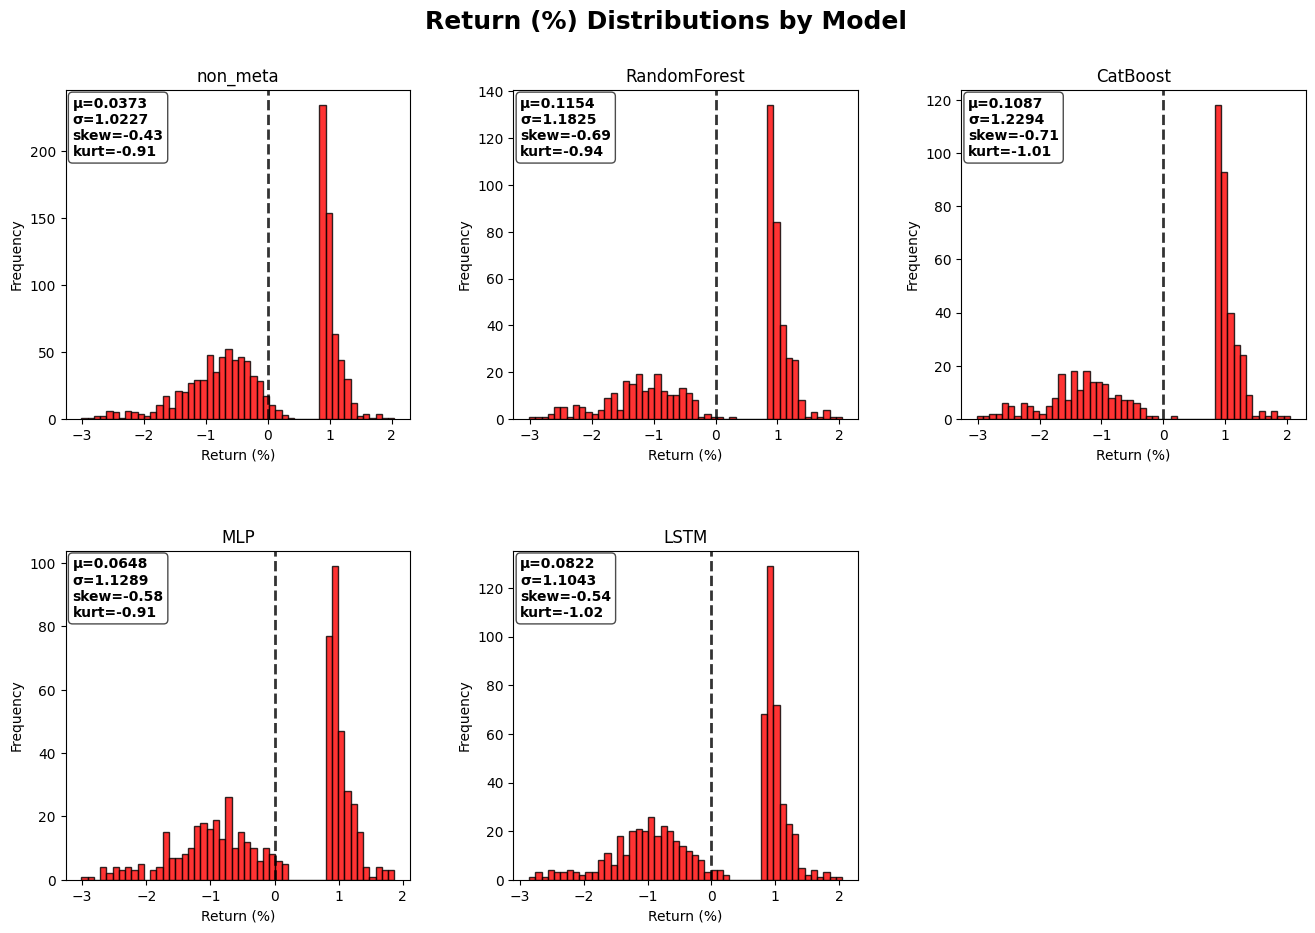

In [60]:
from scipy.stats import skew, kurtosis

fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=False, sharey=False)
axes = axes.flatten()

datasets = [
    (model_test['ret'], 'non_meta'),
    (model_test[model_test['predicted'] == 1]['ret'], 'RandomForest'),
    (gbdt_model_test[gbdt_model_test['predicted'] == 1]['ret'], 'CatBoost'),
    (ANN_test_data[ANN_test_data['predicted'] == 1]['ret'], 'MLP'),
    (LSTM_test_data[LSTM_test_data['predicted'] == 1]['ret'], 'LSTM')
]

for i, (data, label) in enumerate(datasets):
    data = pd.Series(data).dropna()

    # Plot histogram
    data.plot.hist(bins=50, ax=axes[i], title=label, alpha=0.8,
                   color='red', edgecolor='black')
    
    axes[i].set_xlabel('Return (%)')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.8)

    # Calculate statistics
    mean_val = data.mean()
    std_val = data.std()
    skew_val = skew(data)
    kurt_val = kurtosis(data)

    # Annotation
    stats_text = f"μ={mean_val:.4f}\nσ={std_val:.4f}\nskew={skew_val:.2f}\nkurt={kurt_val:.2f}"
    axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes,
                 fontsize=10, verticalalignment='top', horizontalalignment='left',fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Hide unused subplot (6th one)
axes[-1].axis('off')

# Adjust layout
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing between plots
fig.suptitle('Return (%) Distributions by Model', fontsize=18, fontweight='bold')

# Adjust layout to make space for the super title
plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.4)
# Save as SVG with 300 DPI
plt.savefig('Return Distribution by Models.png', format='png', dpi=600, bbox_inches='tight')
plt.show()
